## CosmoFlow Benchmark Scaling Analysis on Summit

In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

def compute_mean_time(r):
    return r[r.epoch>0].time.mean()

def get_num_samples(config):
    dc = config['data']
    return dc['n_train'] + dc['n_valid']

plt.rcParams.update({'font.size': 14})

In [3]:
ranks = np.array([6, 12, 24, 48, 96, 192, 384, 768, 1020])
results_pattern = os.path.expandvars('real/log_%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c) for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_scratch = pd.DataFrame(dict(ranks=ranks, samples=samples,
                                    times=times, throughputs=throughputs))

print(scaling_scratch)

   ranks  samples     times   throughputs
0      6      384  2.438310    157.486159
1     12      768  2.475605    310.227216
2     24     1536  2.598854    591.029778
3     48     3072  2.732879   1124.089153
4     96     6144  2.818809   2179.644054
5    192    12288  2.908948   4224.208056
6    384    24576  3.089087   7955.749327
7    768    49152  3.322992  14791.490854
8   1020    65280  3.392342  19243.344991


In [4]:
ranks = np.array([6, 12, 24, 48, 96, 192, 384, 768, 1020])
results_pattern = os.path.expandvars('dummy/log_%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c)*r for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_dummy = pd.DataFrame(dict(ranks=ranks, samples=samples,
                                  times=times, throughputs=throughputs))

print(scaling_dummy)

   ranks  samples     times   throughputs
0      6      384  2.294221    167.377069
1     12      768  2.211925    347.208937
2     24     1536  2.277796    674.336060
3     48     3072  2.395046   1282.647814
4     96     6144  2.473579   2483.850075
5    192    12288  2.623268   4684.232764
6    384    24576  2.999699   8192.821480
7    768    49152  3.247318  15136.182274
8   1020    65280  3.378735  19320.839663


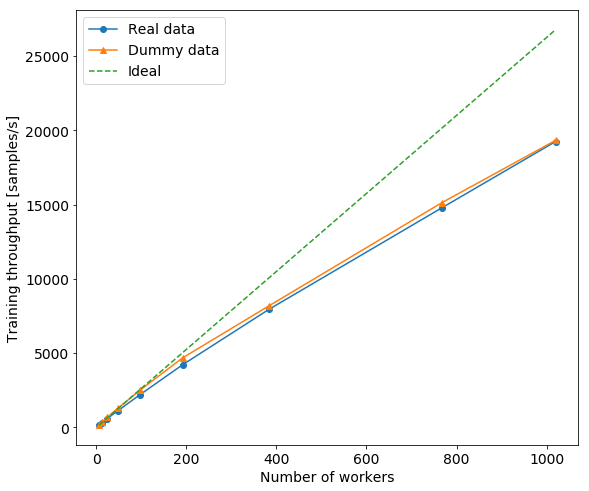

In [5]:
plt.figure(figsize=(9,8))
plt.plot(scaling_scratch['ranks'], scaling_scratch['throughputs'], 'o-', label='Real data')
plt.plot(scaling_dummy['ranks'], scaling_dummy['throughputs'], '^-', label='Dummy data')
plt.xlabel('Number of workers')
plt.ylabel('Training throughput [samples/s]')

plt.plot(scaling_scratch.ranks, scaling_scratch.ranks*scaling_scratch['throughputs'][0]/6, '--', label='Ideal')
plt.legend(loc=0);